In [17]:
import torch.nn as nn
import torch, time
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
%matplotlib inline

# This relates to plotting datetime values using matplotlib
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [8]:
df = pd.read_csv("../PYTORCH_NOTEBOOKS/DATA/TimeSeriesData/Alcohol_Sales.csv",index_col=0,parse_dates=True)
df.head()

,S4248SM144NCEN
DATE,
1992-01-01,3459
1992-02-01,3458
1992-03-01,4002
1992-04-01,4564
1992-05-01,4221


In [9]:
df.shape

(325, 1)

In [10]:
df.columns

Index(['S4248SM144NCEN'], dtype='object')

In [11]:
df = df.dropna()
df.shape

(325, 1)

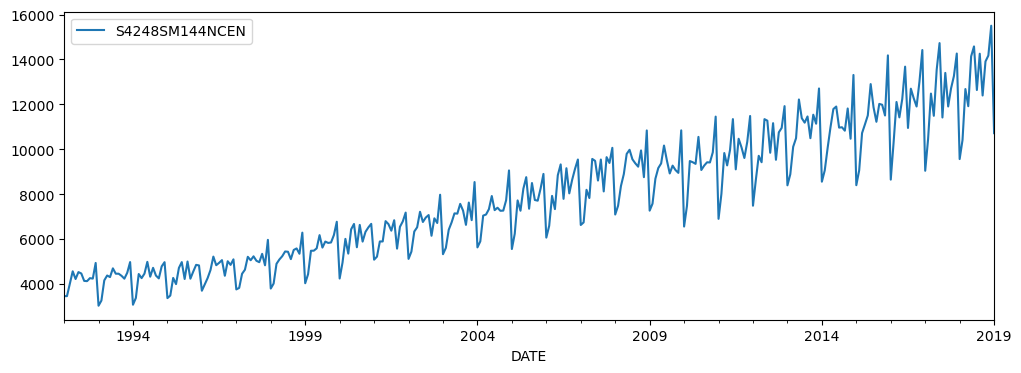

In [12]:
df.plot(figsize=(12,4));

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 325 entries, 1992-01-01 to 2019-01-01
Data columns (total 1 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   S4248SM144NCEN  325 non-null    int64
dtypes: int64(1)
memory usage: 5.1 KB


In [15]:
y = df['S4248SM144NCEN'].astype(float).values
y

array([ 3459.,  3458.,  4002.,  4564.,  4221.,  4529.,  4466.,  4137.,
        4126.,  4259.,  4240.,  4936.,  3031.,  3261.,  4160.,  4377.,
        4307.,  4696.,  4458.,  4457.,  4364.,  4236.,  4500.,  4974.,
        3075.,  3377.,  4443.,  4261.,  4460.,  4985.,  4324.,  4719.,
        4374.,  4248.,  4784.,  4971.,  3370.,  3484.,  4269.,  3994.,
        4715.,  4974.,  4223.,  5000.,  4235.,  4554.,  4851.,  4826.,
        3699.,  3983.,  4262.,  4619.,  5219.,  4836.,  4941.,  5062.,
        4365.,  5012.,  4850.,  5097.,  3758.,  3825.,  4454.,  4635.,
        5210.,  5057.,  5231.,  5034.,  4970.,  5342.,  4831.,  5965.,
        3796.,  4019.,  4898.,  5090.,  5237.,  5447.,  5435.,  5107.,
        5515.,  5583.,  5346.,  6286.,  4032.,  4435.,  5479.,  5483.,
        5587.,  6176.,  5621.,  5889.,  5828.,  5849.,  6180.,  6771.,
        4243.,  4952.,  6008.,  5353.,  6435.,  6673.,  5636.,  6630.,
        5887.,  6322.,  6520.,  6678.,  5082.,  5216.,  5893.,  5894.,
      

In [16]:
test_size = 12
train_set = y[:-test_size]
test_set = y[-test_size:]

In [19]:
scaler = MinMaxScaler(feature_range=(-1,1))
train_norm = scaler.fit_transform(train_set.reshape(-1,1))

In [20]:
train_norm = torch.FloatTensor(train_norm).view(-1)
train_norm

tensor([-0.9268, -0.9270, -0.8340, -0.7379, -0.7966, -0.7439, -0.7547, -0.8109,
        -0.8128, -0.7901, -0.7933, -0.6743, -1.0000, -0.9607, -0.8070, -0.7699,
        -0.7819, -0.7154, -0.7560, -0.7562, -0.7721, -0.7940, -0.7489, -0.6678,
        -0.9925, -0.9408, -0.7586, -0.7897, -0.7557, -0.6660, -0.7790, -0.7114,
        -0.7704, -0.7919, -0.7003, -0.6683, -0.9420, -0.9226, -0.7884, -0.8354,
        -0.7121, -0.6678, -0.7962, -0.6634, -0.7942, -0.7396, -0.6889, -0.6931,
        -0.8858, -0.8373, -0.7896, -0.7285, -0.6260, -0.6914, -0.6735, -0.6528,
        -0.7719, -0.6613, -0.6890, -0.6468, -0.8757, -0.8643, -0.7567, -0.7258,
        -0.6275, -0.6536, -0.6239, -0.6576, -0.6685, -0.6049, -0.6923, -0.4984,
        -0.8692, -0.8311, -0.6808, -0.6480, -0.6229, -0.5870, -0.5890, -0.6451,
        -0.5753, -0.5637, -0.6042, -0.4435, -0.8289, -0.7600, -0.5815, -0.5808,
        -0.5630, -0.4623, -0.5572, -0.5114, -0.5218, -0.5182, -0.4617, -0.3606,
        -0.7928, -0.6716, -0.4911, -0.60

In [22]:
def input_data(sequence,window_size):
    output = []
    L = len(sequence)

    for i in range(L-window_size):
        window = sequence[i:i+window_size]
        label = sequence[i+window_size:i+window_size+1]
        output.append((window,label))

    return output

In [24]:
train_data = input_data(train_norm,window_size=12)
train_data[0]

(tensor([-0.9268, -0.9270, -0.8340, -0.7379, -0.7966, -0.7439, -0.7547, -0.8109,
         -0.8128, -0.7901, -0.7933, -0.6743]),
 tensor([-1.]))

In [25]:
len(train_data) # 325-12(Window size)-12(Test size)

301

In [26]:
class LSTM(nn.Module):

    def __init__(self,input_size=1,hidden_size=100,output_size=1):
        super().__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size,hidden_size)
        self.linear = nn.Linear(hidden_size,output_size)
        self.hidden = (torch.zeros(1,1,hidden_size),torch.zeros(1,1,hidden_size))

    def forward(self,seq):
        lstm_output, self.hidden = self.lstm(seq.view(len(seq),1,-1),self.hidden)
        pred = self.linear(lstm_output.view(len(lstm_output),-1))
        return pred[-1]

In [27]:
torch.manual_seed(42)

model = LSTM()
model

LSTM(
  (lstm): LSTM(1, 100)
  (linear): Linear(in_features=100, out_features=1, bias=True)
)

In [28]:
total_params = 0

for param in model.parameters():
    print(param.numel())
    total_params += param.numel()

print("Total LSTM model parameters:",total_params)

400
40000
400
400
100
1
Total LSTM model parameters: 41301


In [29]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(),lr=0.001)

In [31]:
start_time = time.time()

epochs = 100

for i in range(1,epochs+1):

    for seq, y_train in train_data:
        optimizer.zero_grad()
        model.hidden = (torch.zeros(1,1,model.hidden_size),torch.zeros(1,1,model.hidden_size))
        y_pred = model(seq)
        loss = criterion(y_pred,y_train)
        loss.backward()
        optimizer.step()

    print(f"Epoch {i} -> Loss: {loss.item()}")

print(f"Total time elapsed in LSTM model training: {(time.time()-start_time)/60} minutes.")

Epoch 0 -> Loss: 0.2620842158794403
Epoch 1 -> Loss: 0.34071674942970276
Epoch 2 -> Loss: 0.3732522428035736
Epoch 3 -> Loss: 0.3714459240436554
Epoch 4 -> Loss: 0.32069429755210876
Epoch 5 -> Loss: 0.3305143713951111
Epoch 6 -> Loss: 0.3264331817626953
Epoch 7 -> Loss: 0.3249703347682953
Epoch 8 -> Loss: 0.30683743953704834
Epoch 9 -> Loss: 0.3010622560977936
Epoch 10 -> Loss: 0.2929351031780243
Epoch 11 -> Loss: 0.2860040068626404
Epoch 12 -> Loss: 0.29466769099235535
Epoch 13 -> Loss: 0.27528950572013855
Epoch 14 -> Loss: 0.2910612225532532
Epoch 15 -> Loss: 0.27637743949890137
Epoch 16 -> Loss: 0.2857086658477783
Epoch 17 -> Loss: 0.2875595688819885
Epoch 18 -> Loss: 0.2682710886001587
Epoch 19 -> Loss: 0.26683709025382996
Epoch 20 -> Loss: 0.2633311450481415
Epoch 21 -> Loss: 0.2653793394565582
Epoch 22 -> Loss: 0.25448036193847656
Epoch 23 -> Loss: 0.2700834274291992
Epoch 24 -> Loss: 0.1340695321559906
Epoch 25 -> Loss: 2.7492600565892644e-05
Epoch 26 -> Loss: 0.0011220189044252

In [32]:
future = 12
window_size = 12

predictions = train_norm[-window_size:].tolist()

model.eval()

for i in range(future):
    seq = torch.FloatTensor(predictions[-window_size:])
    with torch.no_grad():
        model.hidden = (torch.zeros(1,1,model.hidden_size),torch.zeros(1,1,model.hidden_size))
        predictions.append(model(seq).item())

In [33]:
predictions[-window_size:]

[0.2686554491519928,
 0.6155226826667786,
 0.4462774693965912,
 0.7974185943603516,
 1.0,
 0.43345585465431213,
 0.772972047328949,
 0.5173946619033813,
 0.6548423171043396,
 0.7488674521446228,
 0.9205060005187988,
 0.11684759706258774,
 0.3047674000263214,
 0.5725451707839966,
 0.5061550736427307,
 0.7541790008544922,
 0.9749622344970703,
 0.4463306665420532,
 0.7396565675735474,
 0.5237860679626465,
 0.5982056260108948,
 0.7188900709152222,
 0.9484802484512329,
 0.14595180749893188]

In [45]:
df['S4248SM144NCEN'][-12:]

DATE
2018-02-01    10415
2018-03-01    12683
2018-04-01    11919
2018-05-01    14138
2018-06-01    14583
2018-07-01    12640
2018-08-01    14257
2018-09-01    12396
2018-10-01    13914
2018-11-01    14174
2018-12-01    15504
2019-01-01    10718
Name: S4248SM144NCEN, dtype: int64

In [34]:
true_predictions = scaler.inverse_transform(np.array(predictions).reshape(-1,1))
true_predictions

array([[10452.00004981],
       [12480.99993226],
       [11491.00005724],
       [13545.00006771],
       [14730.        ],
       [11416.0000218 ],
       [13401.99999085],
       [11907.0000748 ],
       [12711.0001339 ],
       [13261.00016132],
       [14264.99985003],
       [ 9564.00001902],
       [10663.23690645],
       [12229.6029765 ],
       [11841.25410327],
       [13292.0700655 ],
       [14583.54159069],
       [11491.31123394],
       [13207.12109202],
       [11944.38660455],
       [12379.70380935],
       [13085.64746982],
       [14428.63521332],
       [ 9734.24509797]])

In [35]:
df.index

DatetimeIndex(['1992-01-01', '1992-02-01', '1992-03-01', '1992-04-01',
               '1992-05-01', '1992-06-01', '1992-07-01', '1992-08-01',
               '1992-09-01', '1992-10-01',
               ...
               '2018-04-01', '2018-05-01', '2018-06-01', '2018-07-01',
               '2018-08-01', '2018-09-01', '2018-10-01', '2018-11-01',
               '2018-12-01', '2019-01-01'],
              dtype='datetime64[ns]', name='DATE', length=325, freq=None)

In [46]:
x = np.arange('2018-02-01','2019-02-01',dtype='datetime64[M]')
x

array(['2018-02', '2018-03', '2018-04', '2018-05', '2018-06', '2018-07',
       '2018-08', '2018-09', '2018-10', '2018-11', '2018-12', '2019-01'],
      dtype='datetime64[M]')

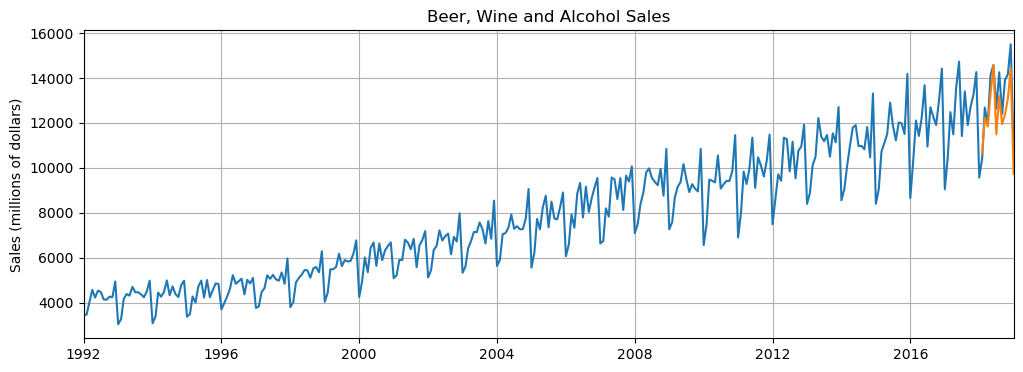

In [48]:
plt.figure(figsize=(12,4))
plt.title('Beer, Wine and Alcohol Sales')
plt.ylabel('Sales (millions of dollars)')
plt.grid(True)
plt.autoscale(axis='x',tight=True)
plt.plot(df['S4248SM144NCEN'])
plt.plot(x,true_predictions[-12:])
plt.show();

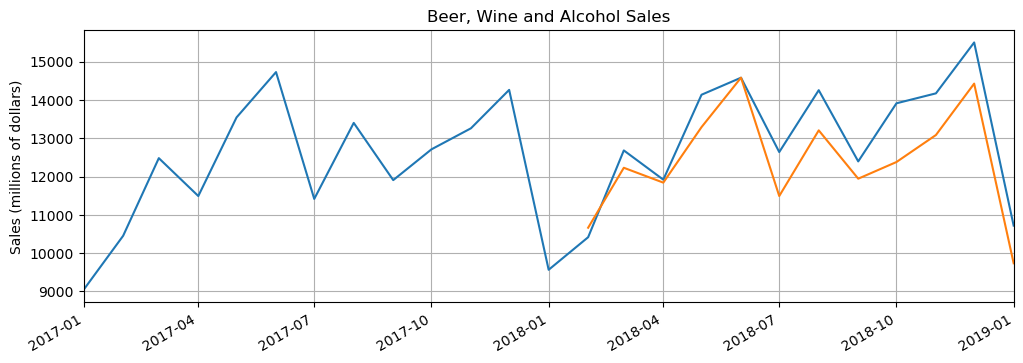

In [51]:
fig = plt.figure(figsize=(12,4))
plt.title('Beer, Wine and Alcohol Sales')
plt.ylabel('Sales (millions of dollars)')
plt.grid(True)
plt.autoscale(axis='x',tight=True)
fig.autofmt_xdate()
plt.plot(df['S4248SM144NCEN']['2017-01-01':])
plt.plot(x,true_predictions[-12:])
plt.show();

In [54]:
epochs = 100

model.train() # Set model back to training model to train on full data

y_norm = scaler.fit_transform(y.reshape(-1,1)) # Perform feature scaling on the entire dataset
y_norm = torch.FloatTensor(y_norm).view(-1) # Convert the normalized data to Torch tensors
all_data = input_data(y_norm,window_size) # Retrieve the normalized data in desired sequence batches for training

start_time = time.time()

for i in range(1,epochs+1):
    
    for seq, y_train in all_data:
        optimizer.zero_grad()
        model.hidden = (torch.zeros(1,1,model.hidden_size),torch.zeros(1,1,model.hidden_size))
        y_pred = model(seq)
        loss = criterion(y_pred,y_train)
        loss.backward()
        optimizer.step()

    print(f"Epoch {i} -> Loss: {loss.item()}")

print(f"Total time elapsed in training LSTM model on entire data = {(time.time()-start_time)/60} minutes.")

Epoch 1 -> Loss: 0.009850793518126011
Epoch 2 -> Loss: 0.0009682996897026896
Epoch 3 -> Loss: 0.00021413994545582682
Epoch 4 -> Loss: 0.01517641544342041
Epoch 5 -> Loss: 0.001143755274824798
Epoch 6 -> Loss: 0.001342552131973207
Epoch 7 -> Loss: 2.259250686620362e-05
Epoch 8 -> Loss: 0.0004544280527625233
Epoch 9 -> Loss: 0.0001445794478058815
Epoch 10 -> Loss: 0.00011643965262919664
Epoch 11 -> Loss: 0.0007824093336239457
Epoch 12 -> Loss: 0.0017667844658717513
Epoch 13 -> Loss: 2.8459873647079803e-05
Epoch 14 -> Loss: 4.133244510740042e-05
Epoch 15 -> Loss: 0.0005263267667032778
Epoch 16 -> Loss: 0.0011150115169584751
Epoch 17 -> Loss: 0.0012862849980592728
Epoch 18 -> Loss: 0.0019444369245320559
Epoch 19 -> Loss: 0.0005794686730951071
Epoch 20 -> Loss: 0.0003352264757268131
Epoch 21 -> Loss: 1.3835520803695545e-05
Epoch 22 -> Loss: 0.0033108515199273825
Epoch 23 -> Loss: 0.0024169564712792635
Epoch 24 -> Loss: 0.0008304236689582467
Epoch 25 -> Loss: 0.00016469848924316466
Epoch 26 

## Forecast into Unknown Future

In [55]:
future = 12
window_size = 12
L = len(y)

predictions = y_norm[-window_size:].tolist()

model.eval()

for i in range(future):
    seq = torch.FloatTensor(predictions[-window_size:])

    with torch.no_grad():
        model.hidden = (torch.zeros(1,1,model.hidden_size),torch.zeros(1,1,model.hidden_size)) # Reset the hidden state and cell state
        pred = model(seq)
        predictions.append(pred.item())

print(predictions)

[0.18399743735790253, 0.5476629734039307, 0.4251583516597748, 0.7809668779373169, 0.8523210287094116, 0.5407680869102478, 0.8000481128692627, 0.5016435384750366, 0.7450492978096008, 0.7867393493652344, 1.0, 0.23258237540721893, 0.402151882648468, 0.7050701975822449, 0.49801868200302124, 0.8927190899848938, 0.9802543520927429, 0.670672595500946, 0.9339752793312073, 0.578224778175354, 0.853645384311676, 0.8801682591438293, 1.0621527433395386, 0.3840060234069824]


In [56]:
predictions[-12:]

[0.402151882648468,
 0.7050701975822449,
 0.49801868200302124,
 0.8927190899848938,
 0.9802543520927429,
 0.670672595500946,
 0.9339752793312073,
 0.578224778175354,
 0.853645384311676,
 0.8801682591438293,
 1.0621527433395386,
 0.3840060234069824]

In [57]:
true_predictions = scaler.inverse_transform(np.array(predictions).reshape(-1,1))
true_predictions

array([[10415.00001808],
       [12683.00013363],
       [11919.00006013],
       [14137.99993426],
       [14583.00009555],
       [12640.00017402],
       [14257.00005591],
       [12395.9999277 ],
       [13913.99994579],
       [14173.99995232],
       [15504.        ],
       [10717.99998423],
       [11775.52021614],
       [13664.67028722],
       [12373.39351031],
       [14834.94260469],
       [15380.85626683],
       [13450.14964184],
       [15092.23682955],
       [12873.59882909],
       [14591.25943926],
       [14756.66934815],
       [15891.61558384],
       [11662.35356498]])

In [58]:
x = np.arange('2019-02-01','2020-02-01',dtype='datetime64[M]')
x

array(['2019-02', '2019-03', '2019-04', '2019-05', '2019-06', '2019-07',
       '2019-08', '2019-09', '2019-10', '2019-11', '2019-12', '2020-01'],
      dtype='datetime64[M]')

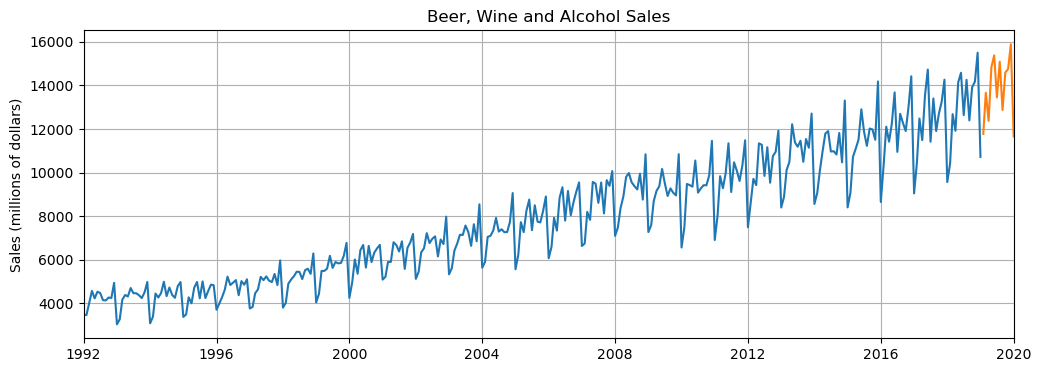

In [59]:
plt.figure(figsize=(12,4))
plt.title('Beer, Wine and Alcohol Sales')
plt.ylabel('Sales (millions of dollars)')
plt.grid(True)
plt.autoscale(axis='x',tight=True)
plt.plot(df['S4248SM144NCEN'])
plt.plot(x,true_predictions[-window_size:])
plt.show();

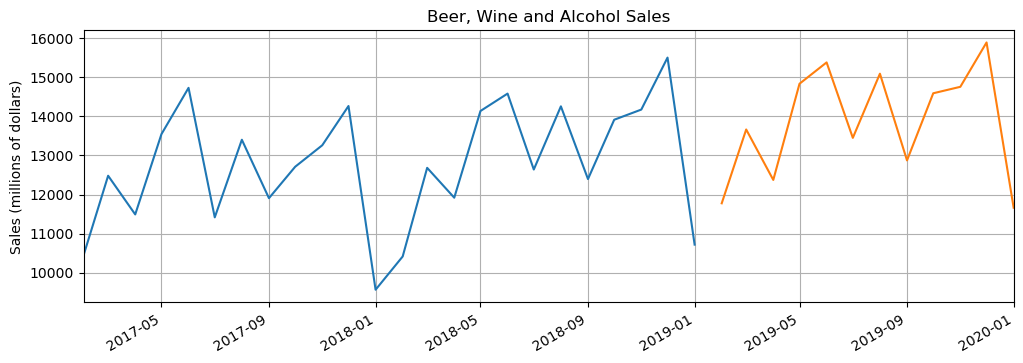

In [61]:
fig = plt.figure(figsize=(12,4))
plt.title('Beer, Wine and Alcohol Sales')
plt.ylabel('Sales (millions of dollars)')
plt.grid(True)
plt.autoscale(axis='x',tight=True)
fig.autofmt_xdate()
plt.plot(df['S4248SM144NCEN']['2017-02-01':])
plt.plot(x,true_predictions[-window_size:]) # Gap is because there are 2 separate plots, there is technically no connection between blue and orange datasets i.e. that is good as we need to keep the forecast horizon completely isolated
plt.show();